# Go directly to the page end and see an explanation

#### When to run this script

This script is meant to be run after test_similarity.py is used to test different cases for the validation and/or test sets. It reads results from results.txt

In [1]:
from __future__ import print_function

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(4)

from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage, MolsToGridImage
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit import DataStructs
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import sys
sys.path.append('../../')
from retrosim.utils.generate_retro_templates import process_an_example
from retrosim.data.get_data import get_data_df, split_data_df
from retrosim.utils.draw import ReactionStringToImage, TransformStringToImage
import os

In [2]:
if os.path.isfile(os.path.join('out', 'results.txt')):
    results = pd.read_csv(os.path.join('out', 'results.txt'), sep='\t')

# Get rid of whitespace
results.columns = [txt.strip() for txt in results.columns]
for fieldstrip in ['dataset', 'getfp_label', 'similarity_label', 'class_']:
    results[fieldstrip] = [txt.strip() for txt in results[fieldstrip]]
results['class_'] = [int(x) if x != 'all' else 'all' for x in results['class_']]
val_results = results.loc[results['dataset'] == 'val']
val_results

,dataset,class_,n_in_class,getfp_label,similarity_label,top-1 acc,top-3 acc,top-5 acc,top-10 acc,top-20 acc,top-50 acc
0,val,10,23,Morgan2noFeat,Tanimoto,0.956522,1.000000,1.000000,1.000000,1.000000,1.000000
1,val,9,183,Morgan2noFeat,Tanimoto,0.377049,0.601093,0.732240,0.836066,0.912568,0.945355
2,val,8,81,Morgan2noFeat,Tanimoto,0.790123,0.925926,0.975309,0.975309,0.975309,0.975309
3,val,7,461,Morgan2noFeat,Tanimoto,0.577007,0.722343,0.817787,0.919740,0.939262,0.945770
4,val,6,824,Morgan2noFeat,Tanimoto,0.483010,0.793689,0.893204,0.939320,0.947816,0.950243
5,val,5,67,Morgan2noFeat,Tanimoto,0.955224,1.000000,1.000000,1.000000,1.000000,1.000000
6,val,4,91,Morgan2noFeat,Tanimoto,0.549451,0.681319,0.681319,0.681319,0.681319,0.681319
7,val,3,566,Morgan2noFeat,Tanimoto,0.438163,0.598940,0.666078,0.754417,0.839223,0.871025
8,val,2,1190,Morgan2noFeat,Tanimoto,0.631933,0.852101,0.902521,0.946218,0.955462,0.957143
9,val,1,1515,Morgan2noFeat,Tanimoto,0.488449,0.688449,0.773597,0.872607,0.917492,0.926073


In [3]:
val_results.loc[val_results['getfp_label']=='Morgan2noFeat'].loc[val_results['similarity_label']=='Tanimoto']

,dataset,class_,n_in_class,getfp_label,similarity_label,top-1 acc,top-3 acc,top-5 acc,top-10 acc,top-20 acc,top-50 acc
0,val,10,23,Morgan2noFeat,Tanimoto,0.956522,1.000000,1.000000,1.000000,1.000000,1.000000
1,val,9,183,Morgan2noFeat,Tanimoto,0.377049,0.601093,0.732240,0.836066,0.912568,0.945355
2,val,8,81,Morgan2noFeat,Tanimoto,0.790123,0.925926,0.975309,0.975309,0.975309,0.975309
3,val,7,461,Morgan2noFeat,Tanimoto,0.577007,0.722343,0.817787,0.919740,0.939262,0.945770
4,val,6,824,Morgan2noFeat,Tanimoto,0.483010,0.793689,0.893204,0.939320,0.947816,0.950243
5,val,5,67,Morgan2noFeat,Tanimoto,0.955224,1.000000,1.000000,1.000000,1.000000,1.000000
6,val,4,91,Morgan2noFeat,Tanimoto,0.549451,0.681319,0.681319,0.681319,0.681319,0.681319
7,val,3,566,Morgan2noFeat,Tanimoto,0.438163,0.598940,0.666078,0.754417,0.839223,0.871025
8,val,2,1190,Morgan2noFeat,Tanimoto,0.631933,0.852101,0.902521,0.946218,0.955462,0.957143
9,val,1,1515,Morgan2noFeat,Tanimoto,0.488449,0.688449,0.773597,0.872607,0.917492,0.926073


In [4]:
val_performance = np.zeros((
    len(np.unique(val_results['similarity_label'])),
    len(np.unique(val_results['getfp_label'])),
    6,        
))
ns = [1, 3, 5, 10, 20, 50]
for i, similarity_label in enumerate(np.unique(val_results['similarity_label'])):
    for j, getfp_label in enumerate(np.unique(val_results['getfp_label'])):
        this_data = val_results.loc[val_results['similarity_label'] == similarity_label].\
             loc[val_results['getfp_label'] == getfp_label].loc[val_results['class_'] != 'all']
        for k, n in enumerate(ns):
            acc_label = 'top-{} acc'.format(n)
            accs = np.array(this_data[acc_label])
            n_in_class = np.array(this_data['n_in_class'])
            overall_acc = sum([accs[z] * n_in_class[z] for z in range(len(accs))]) / np.sum(n_in_class)
            val_performance[i, j, k] = overall_acc

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

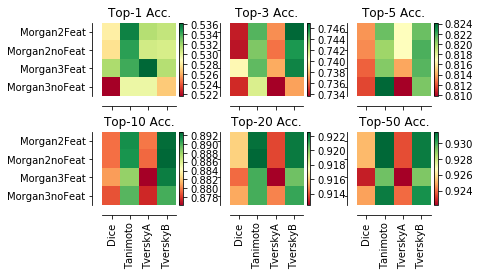

In [6]:
fig, axes = plt.subplots(2,3)
axes = axes.flatten()
for k, n in enumerate(ns):
    ax = axes[k]
    im = ax.imshow(val_performance[:,:,k], cmap='RdYlGn', interpolation='nearest')
    ax.set_xticklabels(['', 0,10,20,30,40])
    ax.set_title('Top-{} Acc.'.format(n))
    #cbar = fig.colorbar(im, ax=ax, ticks=np.arange(0.0, 1.02, 0.002))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, ticks = np.arange(0.0, 1.02, 0.002))
    
    # from http://matplotlib.org/examples/ticks_and_spines/spines_demo_dropped.html
    # Move left and bottom spines outward by 10 points
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.xaxis.set_ticks(range(val_performance.shape[0]))
    if k >= 3:
        ax.xaxis.set_ticklabels(np.unique(val_results['similarity_label']), rotation='vertical')
    else:
        ax.xaxis.set_ticklabels([])
        
    ax.yaxis.set_ticks(range(val_performance.shape[1]))
    if k % 3 == 0:
        ax.yaxis.set_ticklabels(np.unique(val_results['getfp_label']))
    else:
        ax.yaxis.set_ticklabels([])
fig.set_size_inches(17.1/2.54, 4)
plt.tight_layout()


In [7]:
fig.savefig(os.path.join('out', 'validation_results.png'))

# Now when model information not provided

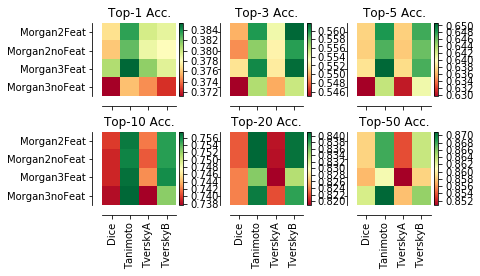

In [8]:
val_performance = np.zeros((
    len(np.unique(val_results['similarity_label'])),
    len(np.unique(val_results['getfp_label'])),
    6,        
))
ns = [1, 3, 5, 10, 20, 50]
for i, similarity_label in enumerate(np.unique(val_results['similarity_label'])):
    for j, getfp_label in enumerate(np.unique(val_results['getfp_label'])):
        this_data = val_results.loc[val_results['similarity_label'] == similarity_label].\
             loc[val_results['getfp_label'] == getfp_label].loc[val_results['class_'] == 'all']
        for k, n in enumerate(ns):
            acc_label = 'top-{} acc'.format(n)
            accs = np.array(this_data[acc_label])
            n_in_class = np.array(this_data['n_in_class'])
            overall_acc = sum([accs[z] * n_in_class[z] for z in range(len(accs))]) / np.sum(n_in_class)
            val_performance[i, j, k] = overall_acc
fig, axes = plt.subplots(2,3)
axes = axes.flatten()
for k, n in enumerate(ns):
    ax = axes[k]
    im = ax.imshow(val_performance[:,:,k], cmap='RdYlGn', interpolation='nearest')
    ax.set_xticklabels(['', 0,10,20,30,40])
    ax.set_title('Top-{} Acc.'.format(n))
    #cbar = fig.colorbar(im, ax=ax, ticks=np.arange(0.0, 1.02, 0.002))
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, ticks = np.arange(0.0, 1.02, 0.002))
    
    # from http://matplotlib.org/examples/ticks_and_spines/spines_demo_dropped.html
    # Move left and bottom spines outward by 10 points
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.xaxis.set_ticks(range(val_performance.shape[0]))
    if k >= 3:
        ax.xaxis.set_ticklabels(np.unique(val_results['similarity_label']), rotation='vertical')
    else:
        ax.xaxis.set_ticklabels([])
        
    ax.yaxis.set_ticks(range(val_performance.shape[1]))
    if k % 3 == 0:
        ax.yaxis.set_ticklabels(np.unique(val_results['getfp_label']))
    else:
        ax.yaxis.set_ticklabels([])
fig.set_size_inches(17.1/2.54, 4)
plt.tight_layout()
fig.savefig(os.path.join('out', 'validation_results_noclassinfo.png'))

## Look at test performance

In [9]:
test_results = results.loc[results['dataset'] == 'test'].loc[results['class_'] != 'all']
test_results.sort_values(['class_'])

,dataset,class_,n_in_class,getfp_label,similarity_label,top-1 acc,top-3 acc,top-5 acc,top-10 acc,top-20 acc,top-50 acc
185,test,1,1516,Morgan2Feat,Tanimoto,0.477573,0.673483,0.771108,0.866755,0.919525,0.927441
184,test,2,1190,Morgan2Feat,Tanimoto,0.631092,0.849580,0.905042,0.942017,0.945378,0.946218
183,test,3,567,Morgan2Feat,Tanimoto,0.380952,0.555556,0.629630,0.746032,0.835979,0.873016
182,test,4,91,Morgan2Feat,Tanimoto,0.516484,0.670330,0.670330,0.670330,0.670330,0.670330
181,test,5,68,Morgan2Feat,Tanimoto,0.897059,0.970588,0.970588,0.970588,0.970588,0.970588
180,test,6,824,Morgan2Feat,Tanimoto,0.508495,0.821602,0.898058,0.955097,0.966019,0.966019
179,test,7,462,Morgan2Feat,Tanimoto,0.573593,0.751082,0.829004,0.883117,0.919913,0.924242
178,test,8,82,Morgan2Feat,Tanimoto,0.853659,0.975610,0.975610,0.987805,0.987805,0.987805
177,test,9,184,Morgan2Feat,Tanimoto,0.418478,0.510870,0.614130,0.711957,0.842391,0.923913
176,test,10,23,Morgan2Feat,Tanimoto,0.913043,0.913043,0.913043,0.913043,0.913043,0.913043


In [10]:
ns = [1, 3, 5, 10, 20, 50]
overall_accs = []
for k, n in enumerate(ns):
    acc_label = 'top-{} acc'.format(n)
    accs = np.array(test_results.loc[test_results['class_'] != 'all'][acc_label])
    n_in_class = np.array(test_results.loc[test_results['class_'] != 'all']['n_in_class'])
    overall_acc = sum([accs[z] * n_in_class[z] for z in range(len(accs))]) / np.sum(n_in_class)
    overall_accs.append(overall_acc)
    print('Top-{} acc on test --> {}'.format(n, overall_acc))

Top-1 acc on test --> 0.529458757739242
Top-3 acc on test --> 0.737567405632197
Top-5 acc on test --> 0.8122628320353683
Top-10 acc on test --> 0.8813660874776328
Top-20 acc on test --> 0.9183143598962845
Top-50 acc on test --> 0.928500099860109


### ...and test performance when class not given

In [11]:
test_results = results.loc[results['dataset'] == 'test'].loc[results['class_'] == 'all']
test_results

,dataset,class_,n_in_class,getfp_label,similarity_label,top-1 acc,top-3 acc,top-5 acc,top-10 acc,top-20 acc,top-50 acc
186,test,all,5007,Morgan2Feat,Tanimoto,0.373277,0.546834,0.633114,0.740763,0.820451,0.853206


In [12]:
ns = [1, 3, 5, 10, 20, 50]
overall_accs = []
for k, n in enumerate(ns):
    acc_label = 'top-{} acc'.format(n)
    accs = np.array(test_results[acc_label])
    n_in_class = np.array(test_results['n_in_class'])
    overall_acc = sum([accs[z] * n_in_class[z] for z in range(len(accs))]) / np.sum(n_in_class)
    overall_accs.append(overall_acc)
    print('Top-{} acc on test --> {}'.format(n, overall_acc))

Top-1 acc on test --> 0.373277411624
Top-3 acc on test --> 0.546834431795
Top-5 acc on test --> 0.633113640903
Top-10 acc on test --> 0.7407629318950001
Top-20 acc on test --> 0.8204513680850001
Top-50 acc on test --> 0.8532055122830001


# Explanation

Each colored piece is a unique combination of fingerprint algorithm and similarity algorithm
SA: Dice , FA: Morgan2Feat , 0.376924615077 of chance in Top 1

There is 0.37692461507700004 of chance to locate the actual reactants (Top 1) of an abitrary class of reaction if all reactions of ALL class are used to conduct product similarity comparison (Algorithms: Dice, Morgan2Feat), which is the first step of retrosim method.

[[ 0.37692462  0.3835233   0.37972406  0.37912418]
 [ 0.37612478  0.3825235   0.37892422  0.37812438]
 [ 0.38072386  0.38532294  0.3815237   0.37932414]
 [ 0.37112577  0.37592482  0.37472505  0.37252549]]


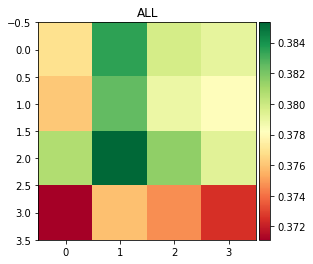

In [13]:
print('Each colored piece is a unique combination of fingerprint algorithm and similarity algorithm')
flag = True
ns = [1, 3, 5, 10, 20, 50]
for i, similarity_label in enumerate(np.unique(val_results['similarity_label'])):
    for j, getfp_label in enumerate(np.unique(val_results['getfp_label'])):
        this_data = val_results.loc[val_results['similarity_label'] == similarity_label].\
             loc[val_results['getfp_label'] == getfp_label].loc[val_results['class_'] == 'all'] # ALL
        for k, n in enumerate(ns):
            acc_label = 'top-{} acc'.format(n)
            accs = np.array(this_data[acc_label])
            n_in_class = np.array(this_data['n_in_class'])
            overall_acc = sum([accs[z] * n_in_class[z] for z in range(len(accs))]) / np.sum(n_in_class)
            val_performance[i, j, k] = overall_acc 
            if flag:
                print('SA:', similarity_label, ', FA:', getfp_label,',', overall_acc, 'of chance in Top', n) 
                print('\nThere is {} of chance to locate the actual reactants (Top 1) of an abitrary class of reaction if all reactions of ALL class are used to conduct product similarity comparison (Algorithms: Dice, Morgan2Feat), which is the first step of retrosim method.\n'.format(overall_acc))
            flag = False
ax = plt.axes()
array = val_performance[:,:,0]
print(array)
im = ax.imshow(array, cmap='RdYlGn', interpolation='nearest') 
ax.set_title('ALL')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks = np.arange(0.0, 1.02, 0.002)) 

Each colored piece is a unique combination of fingerprint algorithm and similarity algorithm
SA: Dice , FA: Morgan2Feat , 0.528294341132 of chance in Top 1

There is 0.5282943411318984 of chance to locate the actual reactants (Top 1) of an abitrary class of reaction if all reactions of ALL class are used to conduct product similarity comparison (Algorithms: Dice, Morgan2Feat), which is the first step of retrosim method.

[[ 0.52829434  0.5354929   0.5314937   0.53109378]
 [ 0.52769446  0.5344931   0.53069386  0.5304939 ]
 [ 0.53169366  0.53409318  0.53629274  0.5314937 ]
 [ 0.52169566  0.52969406  0.52969406  0.52689462]]


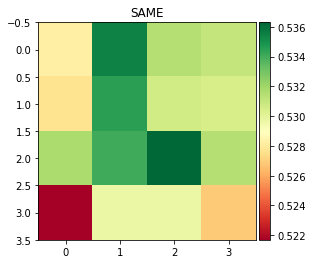

In [14]:
print('Each colored piece is a unique combination of fingerprint algorithm and similarity algorithm')
flag = True
ns = [1, 3, 5, 10, 20, 50]
for i, similarity_label in enumerate(np.unique(val_results['similarity_label'])):
    for j, getfp_label in enumerate(np.unique(val_results['getfp_label'])):
        this_data = val_results.loc[val_results['similarity_label'] == similarity_label].\
             loc[val_results['getfp_label'] == getfp_label].loc[val_results['class_'] != 'all'] # SAME
        for k, n in enumerate(ns):
            acc_label = 'top-{} acc'.format(n)
            accs = np.array(this_data[acc_label])
            n_in_class = np.array(this_data['n_in_class'])
            overall_acc = sum([accs[z] * n_in_class[z] for z in range(len(accs))]) / np.sum(n_in_class)
            val_performance[i, j, k] = overall_acc 
            if flag:
                print('SA:', similarity_label, ', FA:', getfp_label,',', overall_acc, 'of chance in Top', n) 
                print('\nThere is {} of chance to locate the actual reactants (Top 1) of an abitrary class of reaction if all reactions of ALL class are used to conduct product similarity comparison (Algorithms: Dice, Morgan2Feat), which is the first step of retrosim method.\n'.format(overall_acc))
            flag = False
ax = plt.axes()
array = val_performance[:,:,0]
print(array)
im = ax.imshow(array, cmap='RdYlGn', interpolation='nearest') 
ax.set_title('SAME')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks = np.arange(0.0, 1.02, 0.002)) 

If the class of to-be predicted reaction is the same with that of training reactions, a higher chance to locate the actual rectants can be anticipated.